In [1]:
import json
import numpy as np
import os 

In [4]:
gt_file = "storage/explanations_full.json"

global_samples = 2000
sampled_directory = "storage/entropy_explanations"
sampled_files = os.listdir(sampled_directory)
gt_results = json.load(open(gt_file))

In [17]:
def get_sample_size_from_file(file):
    return int(file.split("_")[-1].split(".")[0])

sample_sizes = [get_sample_size_from_file(file) for file in sampled_files]
sample_sizes = sorted(sample_sizes)

In [8]:
sampled_results = {i: json.load(open(sampled_directory + "/" + f)) for i, f in zip(sample_sizes, sampled_files)}


In [9]:
def get_top_k_tokens_per_category(analysis_results: dict, k = 10):
    top_k_tokens = {}
    for category in analysis_results:
        tokens = analysis_results[category]
        tokens = [(t, v) for t, v in tokens.items()]
        tokens = sorted(tokens, key=lambda x: np.abs(x[1]), reverse=True)
        tokens = tokens[:k]
        top_k_tokens[category] = {t: v for t, v in tokens}
    return top_k_tokens    
print("Top 10 tokens per category in ground truth")
print(get_top_k_tokens_per_category(gt_results))

Top 10 tokens per category in ground truth
{'joy': {'winning': 0.43570588093295254, 'entertained': 0.37442486525552654, 'decent': 0.3697268485076623, 'benevolent': 0.2481928904626182, 'convinced': 0.23762154741087654, 'delicious': 0.23095829389103584, 'innocent': 0.22696858699510652, 'unique': 0.22593244297165593, 'glad': 0.2228160014287642, 'cool': 0.22209815072871356}, 'sadness': {'defective': 0.947936092591327, 'sentimental': 0.8741461796528132, 'disadvantaged': 0.8704089204053199, 'tragic': 0.8185530525234761, 'inadequate': 0.8120993653718744, 'melancholy': 0.8045942373559802, 'aching': 0.7698456547689875, 'abused': 0.717048974027787, 'damaged': 0.7150775710000353, 'fake': 0.706181907567752}, 'anger': {'appalled': 0.7539517345453115, 'distracted': 0.6408279153974414, 'fucked': 0.6188905806282229, 'rebellious': 0.5958198078002498, 'aggravated': 0.5830096120201007, 'dissatisfied': 0.562194087521132, 'rushed': 0.5585160967075898, 'violent': 0.5512250672290656, 'angered': 0.55076837748

In [31]:
def compute_mae(gt_results, sampled_resutls, top_k = 10):
    # computes MAE on top_k tokens per category
    # if a token from gt is not in sampled, it gets skipped in MAE computation
    mae = 0
    gt_top_k = get_top_k_tokens_per_category(gt_results, top_k)
    for category in gt_top_k:
        gt_tokens = gt_top_k[category]
        sampled_tokens = sampled_resutls.get(category, {})
        for token in gt_tokens:
            if token in sampled_tokens:
                mae += np.abs(gt_tokens[token] - sampled_tokens[token])
            else:
                mae += np.abs(gt_tokens[token])
    return mae / (top_k * len(gt_top_k))

def recall_at_k(gt_results, sampled_results, top_k = 10):
    # computes how many tokens from top_k in gt are in top_k in sampled
    recall = 0
    gt_top_k = get_top_k_tokens_per_category(gt_results, top_k)
    sampled_tokens_all = get_top_k_tokens_per_category(sampled_results, top_k)
    for category in gt_top_k:
        gt_tokens = gt_top_k[category]
        sampled_tokens_category = sampled_tokens_all.get(category, {})
        for token in gt_tokens:
            if token in sampled_tokens_category:
                recall += 1
    return recall / (top_k * len(gt_top_k))


# compute MAE between top 10 results in ground truth and sampled results
def compute_mae_and_hit_rate(gt_results, sampled_results, top_k = 10):
    # computes MAE on top_k tokens per category
    # if a token from gt is not in sampled, it gets skipped in MAE computation
    # also computes how many tokens from top_k in gt are in top_k in sampled
    # sampled is dict for one sample rate
    mae = 0
    hit_rate = 0
    gt_top_k = get_top_k_tokens_per_category(gt_results, top_k)
    sampled_top_k = get_top_k_tokens_per_category(sampled_results, top_k)
    for category in gt_top_k:
        gt_tokens = gt_top_k[category]
        sampled_tokens = sampled_top_k.get(category, {})
        for token in gt_tokens:
            if token in sampled_tokens:
                hit_rate += 1
                mae += np.abs(gt_tokens[token] - sampled_tokens[token])
            # else:
            #     mae += np.abs(gt_tokens[token])
    print(mae, hit_rate)
    if hit_rate == 0:
        return 1, 0
    return mae / hit_rate, hit_rate / (top_k * len(gt_top_k))


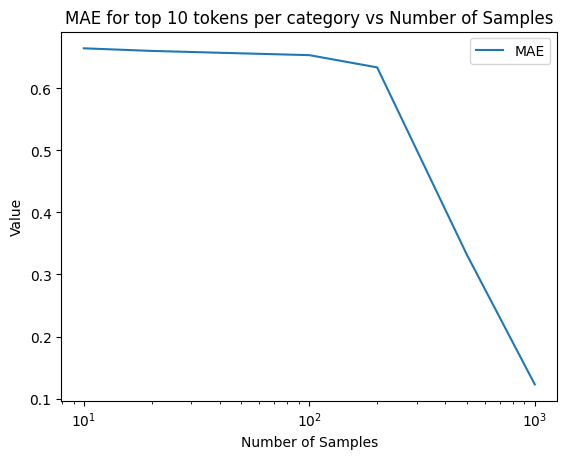

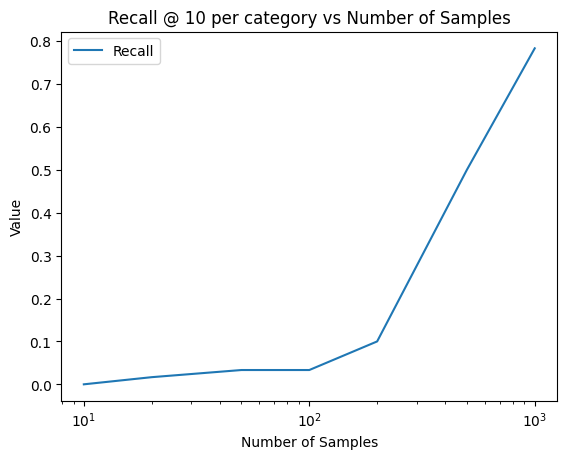

In [32]:
# graph the results of mae and hit rate
import matplotlib.pyplot as plt
maes_10 = []
recalls_at_10 = []
sample_sizes
for size in sample_sizes:
    mae = compute_mae(gt_results, sampled_results[size], 10)
    maes_10.append(mae)
    recalls_at_10.append(recall_at_k(gt_results, sampled_results[size], 10))
plt.plot(sample_sizes, maes_10, label="MAE")
plt.title("MAE for top 10 tokens per category vs Number of Samples")
plt.xlabel("Number of Samples")
# x axis should be log scale
plt.xscale("log")
plt.ylabel("Value")
plt.legend()
plt.savefig("mae_vs_samples_entropy.png")
plt.show()
plt.plot(sample_sizes, recalls_at_10, label="Recall")
plt.title("Recall @ 10 per category vs Number of Samples")
plt.xlabel("Number of Samples")
# x axis should be log scale
plt.xscale("log")
plt.ylabel("Value")
plt.legend()
plt.savefig("hit_rate_vs_samples_entropy.png")
plt.show()